# Swissborg Data Analysis

## Libs & Help Functions

In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
def query_table(query_text):
    result = sqldf(query_text, globals())
    return result

## Datasets

In [3]:
df_user = pd.read_csv('business_data_analyst_tech_challenge_2023_h2_user_data.csv')
df_transactions = pd.read_csv('business_data_analyst_tech_challenge_2023_h2_transaction_data.csv')

In [4]:
dim_user = query_table('SELECT * FROM df_user')

In [5]:
fct_transactions = query_table('SELECT * FROM df_transactions')

# SQL challenges

## Task 1

#### 1- Write a query that gives the number of users passing each step of the activation funnel (installation - verification - deposit - purchase of any thematic bundle), broken down per country, with conversion rates between each step as well as the overall conversion rate from the start of the user funnel.

In [6]:
funnel_by_country = query_table(
    '''
    WITH app_installation_counts AS 
(
   SELECT
      country_code,
      COUNT(user_id) AS app_installation_count 
   FROM
      dim_user 
   GROUP BY
      1 
)
,
verified_account_counts AS 
(
   SELECT
      country_code,
      COUNT(user_id) AS verified_account_count 
   FROM
      dim_user 
   WHERE
      verified_at IS NOT NULL 
   GROUP BY
      1 
)
,
first_deposit_counts AS 
(
   SELECT
      country_code,
      COUNT(user_id) AS first_deposit_count 
   FROM
      dim_user 
   WHERE
      overall_first_deposit_timestamp IS NOT NULL 
   GROUP BY
      1 
)
,
thematic_purchase_counts AS 
(
   SELECT
      u.country_code,
      COUNT(DISTINCT t.user_id) AS thematic_purchase_count 
   FROM
      fct_transactions AS t 
      LEFT JOIN
         dim_user AS u 
         ON t.user_id = u.user_id 
   WHERE
      t.web3_thematic_purchase_usd IS NOT NULL 
      OR t.golden_thematic_purchase_usd IS NOT NULL 
   GROUP BY
      1 
)
SELECT
   ia.country_code,
   ia.app_installation_count AS app_installation,
   va.verified_account_count AS verified_account,
   ROUND(CAST(va.verified_account_count AS float) / ia.app_installation_count * 100.0, 2) AS verification_rate_percentage,
   fd.first_deposit_count AS first_deposit,
   ROUND(CAST(fd.first_deposit_count AS float) / va.verified_account_count * 100.0, 2) AS first_deposit_rate_percentage,
   ROUND(CAST(fd.first_deposit_count AS float) / ia.app_installation_count * 100.0, 2) AS overall_first_deposit_rate_percentage,
   tp.thematic_purchase_count AS thematic_purchase,
   ROUND(CAST(tp.thematic_purchase_count AS float) / fd.first_deposit_count * 100.0, 2) AS thematic_purchase_rate_percentage,
   ROUND(CAST(tp.thematic_purchase_count AS float) / ia.app_installation_count * 100.0, 2) AS overall_purchase_rate_percentage 
FROM
   app_installation_counts AS ia 
   LEFT JOIN
      verified_account_counts AS va 
      ON ia.country_code = va.country_code 
   LEFT JOIN
      first_deposit_counts AS fd 
      ON ia.country_code = fd.country_code 
   LEFT JOIN
      thematic_purchase_counts AS tp 
      ON ia.country_code = tp.country_code
''')

funnel_by_country

,country_code,app_installation,verified_account,verification_rate_percentage,first_deposit,first_deposit_rate_percentage,overall_first_deposit_rate_percentage,thematic_purchase,thematic_purchase_rate_percentage,overall_purchase_rate_percentage
0,None,5815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD,12,6.0,50.00,2.0,33.33,16.67,NaN,NaN,NaN
2,AE,167,118.0,70.66,43.0,36.44,25.75,3.0,6.98,1.80
3,AR,191,89.0,46.60,11.0,12.36,5.76,NaN,NaN,NaN
4,AT,214,173.0,80.84,104.0,60.12,48.60,12.0,11.54,5.61
...,...,...,...,...,...,...,...,...,...,...
78,UY,2,2.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN
79,VN,88,47.0,53.41,6.0,12.77,6.82,NaN,NaN,NaN
80,YT,18,9.0,50.00,1.0,11.11,5.56,NaN,NaN,NaN
81,ZA,128,68.0,53.13,20.0,29.41,15.63,7.0,35.00,5.47


#### 2- Write a query that returns a daily time series of the 14-day rolling net deposit-withdrawal amount per country for 2023 H1.

In [7]:
net_deposit_withdrawl_amount = query_table(
    '''
WITH RECURSIVE date_sequence AS (
   SELECT
      DATE('2023-01-01') AS transaction_timestamp 
   UNION ALL
   SELECT
      DATE(transaction_timestamp, '+1 day') 
   FROM
      date_sequence 
   WHERE
      transaction_timestamp <= DATE('2023-06-30') 
)
,
country_sequence AS (
   SELECT DISTINCT
      country_code 
   FROM
      dim_user 
   WHERE
      country_code IS NOT NULL 
)
,
every_date_per_country AS (
   SELECT
      transaction_timestamp,
      country_code 
   FROM
      date_sequence 
      CROSS JOIN
         country_sequence 
)
,
daily_transactions AS (
   SELECT
      ft.*,
      du.country_code,
      du.total_claimed_wealth_usd,
      du.age 
   FROM
      fct_transactions AS ft 
      LEFT JOIN
         dim_user AS du 
         ON ft.user_id = du.user_id 
)
,
final AS (
   SELECT
      e.transaction_timestamp AS transaction_timestamp,
      e.country_code,
      COALESCE(SUM(d.deposit_usd) - SUM(d.withdrawal_usd),0) AS net_deposit_withdrawal_amount,
      COALESCE(
         SUM(SUM(d.deposit_usd) - SUM(d.withdrawal_usd)) OVER (
         PARTITION BY e.country_code 
         ORDER BY e.transaction_timestamp ASC 
         ROWS BETWEEN 13 PRECEDING AND CURRENT ROW
      ), 0) AS rolling_net_deposit_withdrawal_amount 
   FROM
      every_date_per_country AS e 
      LEFT JOIN
         daily_transactions AS d 
         ON e.transaction_timestamp = d.timestamp 
         AND e.country_code = d.country_code 
   GROUP BY
      e.transaction_timestamp,
      e.country_code 
   ORDER BY
      e.country_code,
      e.transaction_timestamp 
)
SELECT
   * 
FROM
   final
''')

net_deposit_withdrawl_amount

,transaction_timestamp,country_code,net_deposit_withdrawal_amount,rolling_net_deposit_withdrawal_amount
0,2023-01-01,AD,0.0,0.0
1,2023-01-02,AD,0.0,0.0
2,2023-01-03,AD,0.0,0.0
3,2023-01-04,AD,0.0,0.0
4,2023-01-05,AD,0.0,0.0
...,...,...,...,...
14919,2023-06-27,ZM,0.0,0.0
14920,2023-06-28,ZM,0.0,0.0
14921,2023-06-29,ZM,0.0,0.0
14922,2023-06-30,ZM,0.0,0.0


#### 3- Write a query and create a corresponding chart that you believe the best highlights the similarities or differences of the distribution of investment amounts into the web3 and golden thematics

#### A: Boxplot will be usefull to visualize the distribution of amounts for Web3 and Golden Thematics products. With it we can confirm that users are investing higher amounts on Golden in comparison to Web3. I removed the outliers to make the box quartiles visible.

##### With Outliers

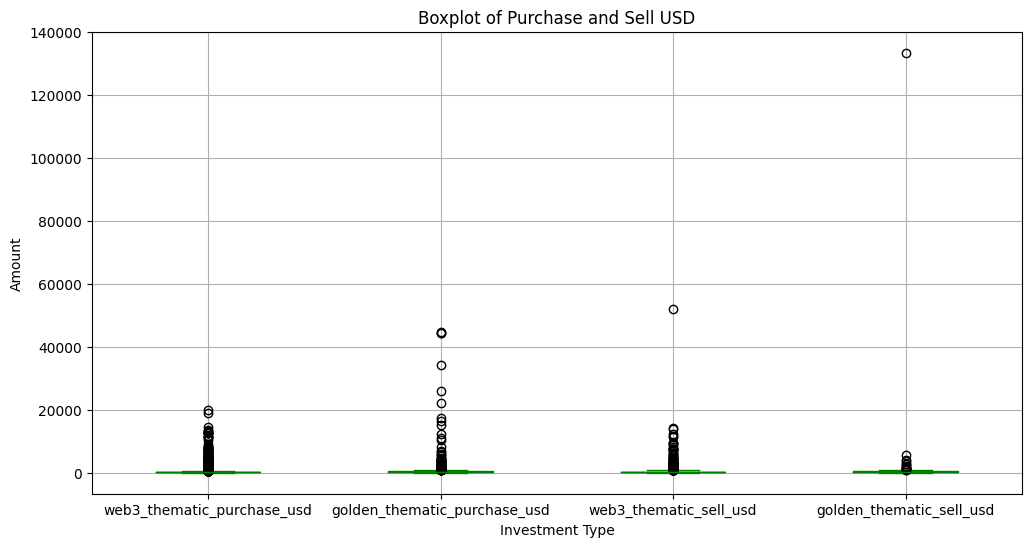

In [8]:
web3_and_golden_thematic = query_table('''
SELECT
    web3_thematic_purchase_usd,
    web3_thematic_sell_usd,
    golden_thematic_purchase_usd,
    golden_thematic_sell_usd
FROM
    fct_transactions AS ft 
''')

plt.figure(figsize=(12, 6))  

web3_and_golden_thematic.boxplot(column=['web3_thematic_purchase_usd', 'golden_thematic_purchase_usd', 'web3_thematic_sell_usd', 'golden_thematic_sell_usd'], color='green')

plt.title('Boxplot of Purchase and Sell USD')
plt.xlabel('Investment Type')
plt.ylabel('Amount')

plt.show()

##### Without Outliers

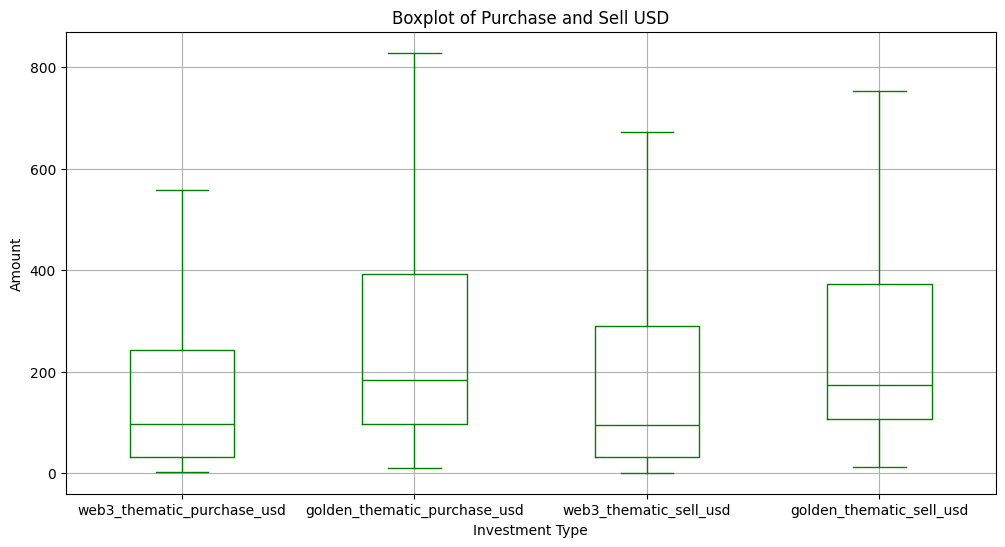

In [9]:
web3_and_golden_thematic = query_table('''
SELECT
    web3_thematic_purchase_usd,
    web3_thematic_sell_usd,
    golden_thematic_purchase_usd,
    golden_thematic_sell_usd
FROM
    fct_transactions AS ft 
''')

plt.figure(figsize=(12, 6))  

web3_and_golden_thematic.boxplot(column=['web3_thematic_purchase_usd', 'golden_thematic_purchase_usd', 'web3_thematic_sell_usd', 'golden_thematic_sell_usd'], showfliers=False, color='green')

plt.title('Boxplot of Purchase and Sell USD')
plt.xlabel('Investment Type')
plt.ylabel('Amount')

plt.show()